# CS6700: Reinforcement Learning - Tutorial 1 (MENACE)

#### Tasks
1. Complete code to determine if there is a winner at a particular state
2. Complete code to update state-action values of a player based on play history
3. Plot win, draw and loss %ages while training MENACE vs MENACE
4. Plot win, draw and loss %ages while training MENACE vs Random policy
5. Report any observations and inferences from the plots in 3 & 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple
from google.colab import output

In [3]:
SEED = 0
NUM_EPOCHS = 1_00_000

BOARD_COL = 3
BOARD_ROW = 3
BOARD_SIZE = BOARD_COL * BOARD_ROW

"""
Game board and actions are: {q, w, e, a, s, d, z, x, c}

q | w | e
--|---|--
a | s | d
--|---|--
z | x | c
"""
ACTIONS_KEY_MAP = {'q': 0, 'w': 1, 'e': 2,
                   'a': 3, 's': 4, 'd': 5,
                   'z': 6, 'x': 7, 'c': 8}

In [4]:
np.random.seed(SEED)

## State Definition

In [5]:
def print_state(board, clear_output=False):
  if clear_output:
    output.clear()
  for i in range(BOARD_ROW):
    print('-------------')
    out = '| '
    for j in range(BOARD_COL):
      if board[i, j] == 1:
          token = 'x'
      elif board[i, j] == -1:
          token = 'o'
      else:
          token = ' '  # empty position
      out += token + ' | '
    print(out)
  print('-------------')


class State:
  def __init__(self, symbol):
    # the board is represented by an n * n array,
    #  1 represents the player who moves first (X),
    # -1 represents another player (O)
    #  0 represents an empty position
    self.board = np.zeros((BOARD_ROW, BOARD_COL))
    self.symbol = symbol
    self.winner = 0
    self.end = None

  @property
  def hash_value(self):
    hash = 0
    for x in np.nditer(self.board):
      hash = 3*hash + x + 1   # unique hash
    return hash

  def next(self, action: str):
    id = ACTIONS_KEY_MAP[action]
    i, j = id // BOARD_COL, id % BOARD_COL
    return self.next_by_pos(i, j)

  def next_by_pos(self, i: int, j: int):
    assert self.board[i, j] == 0
    new_state = State(-self.symbol)      # another player turn
    new_state.board = np.copy(self.board)
    new_state.board[i, j] = self.symbol  # current player choose to play at (i, j) pos
    return new_state

  @property
  def possible_actions(self):
    rev_action_map = {id: key for key, id in ACTIONS_KEY_MAP.items()}
    actions = []
    for i in range(BOARD_ROW):
      for j in range(BOARD_COL):
        if self.board[i, j] == 0:
          actions.append(rev_action_map[BOARD_COL*i+j])
    return actions

  def is_end(self):
    # if self.end is not None:
    #   return self.end


    ### WRITE YOUR CODE HERE ###
    # check 3 rows, 3 columns and both diagonals
    # check if the state is an end state
    # set self.end to be True when the game has ended
    # set self.winner to be 0 (draw), 1 (player 1) or 2 (player 2)


    #Case 1 : Check Row-Wins
    for i in range(BOARD_ROW):
      if np.all(self.board[i] == 1) or np.all(self.board[i] == -1):
        self.end = True
        if np.all(self.board[i] == 1):
          self.winner = 1
        else:
          self.winner = 2
        break
      else:
        pass
    #If any row wins : self.end == True, else self.end reamins None

    #Case 2 : Check Col-Wins
    transpose_board = np.transpose(self.board) #Transpose the board to check for "columns"

    for i in range(BOARD_COL):
      if np.all(transpose_board[i] == 1) or np.all(transpose_board[i] == -1):
        self.end = True
        if np.all(transpose_board[i] == 1):
          self.winner = 1
        else:
          self.winner = 2
        break
      else:
        pass
    #If any col wins : self.end == True, else self.end remains None

    #Case 3 : Check for diagonal-wins
    if (BOARD_ROW == BOARD_COL):
      diagonal_1 = np.array([self.board[i,i] for i in range(BOARD_ROW)])
      diagonal_2 = np.array([self.board[i,-i-1] for i in range(BOARD_ROW)])

      if (np.all(diagonal_1 == 1) or np.all(diagonal_2 == 1)):
        self.winner = 1
        self.end = True
      elif (np.all(diagonal_1 == -1) or np.all(diagonal_2 == -1)):
        self.winner = 2
        self.end = True
      else:
          pass
    else:
      print("CANNOT get diagonal victories with unsymmetric boards.")
    #If any diagonal-wins, self.end == True, else, self.end remains None

    if self.end is not None:
      return self.end

    # if there is no winner
    # check if there are any available plays
    for x in np.nditer(self.board):
      if x == 0:
        self.end = False
        return self.end

    # declare a draw
    self.winner = 0
    self.end = True
    return self.end

## Environment

In [6]:
class Env:
  def __init__(self):
    self.all_states = self.get_all_states()
    self.curr_state = State(symbol=1)

  def get_all_states(self):
    all_states = {}  # is a dict with key as state_hash_value and value as State object.
    def explore_all_substates(state):
      for i in range(BOARD_ROW):
        for j in range(BOARD_COL):
          if state.board[i, j] == 0:
            next_state = state.next_by_pos(i, j)
            if next_state.hash_value not in all_states:
              all_states[next_state.hash_value] = next_state
              if not next_state.is_end():
                explore_all_substates(next_state)
    curr_state = State(symbol=1)
    all_states[curr_state.hash_value] = curr_state
    explore_all_substates(curr_state)
    return all_states

  def reset(self):
    self.curr_state = State(symbol=1)
    return self.curr_state

  def step(self, action):
    assert action in self.curr_state.possible_actions, f"Invalid {action} for the current state \n{self.curr_state.print_state()}"
    next_state_hash = self.curr_state.next(action).hash_value
    next_state = self.all_states[next_state_hash]
    self.curr_state = next_state
    reward = 0
    return self.curr_state, reward

  def is_end(self):
    return self.curr_state.is_end()

  @property
  def winner(self):
    result_id = self.curr_state.winner
    result = 'draw'
    if result_id == 1:
      result = 'player1'
    elif result_id == 2:
      result = 'player2'
    return result

## Policy

In [7]:
class BasePolicy:
  def reset(self):
    pass

  def update_values(self, *args):
    pass

  def select_action(self, state):
    raise Exception('Not Implemented Error')

In [8]:
class HumanPolicy(BasePolicy):
  def __init__(self, symbol):
    self.symbol = symbol

  def select_action(self, state):
    assert state.symbol == self.symbol, f"Its not {self.symbol} symbol's turn"
    print_state(state.board, clear_output=True)
    key = input("Input your position: ")
    return key

In [9]:
class RandomPolicy(BasePolicy):
  def __init__(self, symbol):
    self.symbol = symbol

  def select_action(self, state):
    assert state.symbol == self.symbol, f"Its not {self.symbol} symbol's turn"
    return np.random.choice(state.possible_actions)

In [24]:
class ActionPlayed(NamedTuple):
  hash_value: str
  action: str


class MenacePolicy(BasePolicy):
  def __init__(self, all_states, symbol, tau=5.0):
    self.all_states = all_states
    self.symbol = symbol
    self.tau = tau

    # It store the number of stones for each action for each state
    self.state_action_value = self.initialize()
    # variable to store the history for updating the number of stones
    self.history = []

  def initialize(self):
    state_action_value = {}
    for hash_value, state in self.all_states.items():
      # initially all actions have 0 stones
      state_action_value[hash_value] = {action: 0 for action in state.possible_actions}
    return state_action_value

  def reset(self):
    for action_value in self.state_action_value.values():
      for action in action_value.keys():
        action_value[action] = 0

  def print_updates(self, reward):
    print(f'Player with symbol {self.symbol} updates the following history with {reward} stone')
    for item in self.history:
      board = np.copy(self.all_states[item.hash_value].board)
      id = ACTIONS_KEY_MAP[item.action]
      i, j = id//BOARD_COL, id%BOARD_COL
      board[i, j] = self.symbol
      print_state(board)

  def update_values(self, reward, show_update=False):
    # reward: if wins receive reward of 1 stone for the chosen action
    #         else -1 stone.
    # reward is either 1 or -1 depending upon if the player has won or lost the game.

    if show_update:
      self.print_updates(reward)

    # for every state-action in history
    # use reward to update the state-action values
    ### WRITE CODE HERE
    for action_played in self.history:
      hash = action_played.hash_value
      action = action_played.action
      self.state_action_value[hash][action] += reward


    self.history = []


  def select_action(self, state):  # Softmax action probability
    assert state.symbol == self.symbol, f"Its not {self.symbol} symbol's turn"
    action_value = self.state_action_value[state.hash_value]
    max_value = action_value[max(action_value, key=action_value.get)]
    exp_values = {action: np.exp((v-max_value) / self.tau) for action, v in action_value.items()}
    normalizer = np.sum([v for v in exp_values.values()])
    prob = {action: v/normalizer for action, v in exp_values.items()}
    action = np.random.choice(list(prob.keys()), p=list(prob.values()))
    self.history.append(ActionPlayed(state.hash_value, action))
    return action

## Game Board

In [12]:
class Game:
  def __init__(self, env, player1, player2):
    self.env = env
    self.player1 = player1
    self.player2 = player2
    self.show_updates = False
    self.train_results = None

  def alternate(self):
    while True:
      yield self.player1
      yield self.player2

  def train(self, epochs=1_00_000):
    self.train_results = [[], []]
    player1_reward_map = {'player1': 1, 'player2': -1, 'draw': 0}
    for _ in range(epochs):
      result = self.play()

      # if player1 wins add 1 stone for the action chosen
      player1_reward = player1_reward_map[result]
      player2_reward = -player1_reward   # if player2 wins add 1 stone

      self.player1.update_values(player1_reward)
      self.player2.update_values(player2_reward)

      # append results
      self.train_results[0].append(player1_reward)
      self.train_results[1].append(player2_reward)

  def play(self):
    alternate = self.alternate()
    state = self.env.reset()
    while not self.env.is_end():
      player = next(alternate)
      action = player.select_action(state)
      state, _ = self.env.step(action)
    result = self.env.winner
    return result

## Experiments

In [25]:
env = Env()

# Game 1: train MENACE vs MENACE
# plot win, draw, loss fractions for player 1
player1 = MenacePolicy(env.all_states, symbol=1)
player2 = MenacePolicy(env.all_states, symbol=-1)
game1 = Game(env, player1, player2)
game1.train(epochs=NUM_EPOCHS)

# GAME 2: train MENACE vs RANDOM
# plot win, draw, loss fractions for player 3
player3 = MenacePolicy(env.all_states, symbol=1)
player4 = RandomPolicy(symbol=-1)
game2 = Game(env, player3, player4)
game2.train(epochs=NUM_EPOCHS)

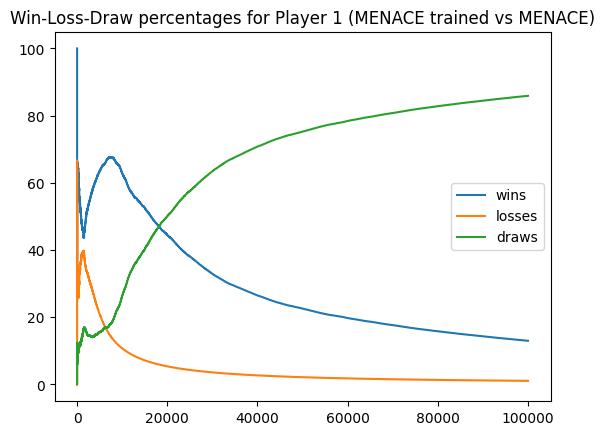

In [26]:
results1 = game1.train_results[0]
wins1, draws1, losses1, tot1 = 0., 0., 0., 0.
fracs1 = [[], [], []]
for i in range(NUM_EPOCHS):
  tot1 += 1
  if results1[i] == 1: wins1 += 1
  elif results1[i] == 0: draws1 += 1
  else: losses1 += 1

  fracs1[0].append((wins1/tot1)*100)
  fracs1[1].append((losses1/tot1)*100)
  fracs1[2].append((draws1/tot1)*100)

plt.plot(range(NUM_EPOCHS), fracs1[0], label = 'wins')
plt.plot(range(NUM_EPOCHS), fracs1[1], label = 'losses')
plt.plot(range(NUM_EPOCHS), fracs1[2], label = 'draws')
plt.title('Win-Loss-Draw percentages for Player 1 (MENACE trained vs MENACE)')
plt.legend()
plt.show()

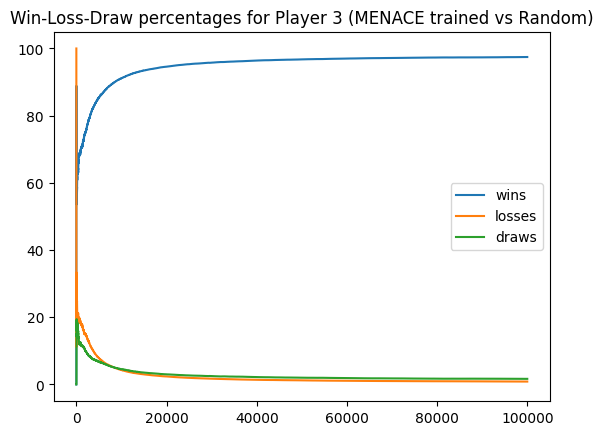

In [27]:
results2 = game2.train_results[0]
wins2, draws2, losses2, tot2 = 0., 0., 0., 0.
fracs2 = [[], [], []]
for i in range(NUM_EPOCHS):
  tot2 += 1
  if results2[i] == 1: wins2 += 1
  elif results2[i] == 0: draws2 += 1
  else: losses2 += 1

  fracs2[0].append((wins2/tot2)*100)
  fracs2[1].append((losses2/tot2)*100)
  fracs2[2].append((draws2/tot2)*100)

plt.plot(range(NUM_EPOCHS), fracs2[0], label = 'wins')
plt.plot(range(NUM_EPOCHS), fracs2[1], label = 'losses')
plt.plot(range(NUM_EPOCHS), fracs2[2], label = 'draws')
plt.title('Win-Loss-Draw percentages for Player 3 (MENACE trained vs Random)')
plt.legend()
plt.show()

In [28]:
# GAME 3: Play against player 1 (MENACE trained vs MENACE)
# See if you can beat this policy!

game3 = Game(env, player1, HumanPolicy(symbol=-1))
game3.play()

result = env.winner
print(f"winner: {result}")

player1_reward_map = {'player1': 1, 'player2': -1, 'draw': 0}
player1.update_values(player1_reward_map[result], show_update=True)

-------------
| x |   |   | 
-------------
|   | x |   | 
-------------
| x | o | o | 
-------------
Input your position: a
winner: player1
Player with symbol 1 updates the following history with 1 stone
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   |   | 
-------------
|   | x |   | 
-------------
|   | o |   | 
-------------
-------------
| x |   |   | 
-------------
|   | x |   | 
-------------
| x | o | o | 
-------------
-------------
| x |   | x | 
-------------
| o | x |   | 
-------------
| x | o | o | 
-------------


#### Question

What can you infer from the above series of experiments?

**ENTER ANSWER HERE**

MENACE is a well crafted RL algorithm that is built upon the fundamental notion of learning via repititve failures. Balanced rewarding of positive and negative reinforcements is crucial, so as to not have the model run in circles in either failure, or a supposedly clever shortcut to get infinite rewards, and actually learn its way to the defined end-goal.

The experiment itself is numerically expensive, with the training time taking well over 10 minutes for 1_00_000 EPOCHs.

The final model was well trained, and managed to beat a human player!